# ST456 Final Project Codebook
# Deep Learning for Bone Fracture Classification for Medical Images
# Candidate Numbers: 43399, 40974, 39639, 37140

In [ ]:
# Importing all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import collections
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from keras.regularizers import l2
from matplotlib import cm
from PIL import Image
import kagglehub
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Part 1:**

The first part of this notebook demonstrates the training and evaluation of a binary classifier on the FracAtlas dataset. The aim is to train a classifier predicting whether an X-ray image is Fractured or Not fractured. We mainly do this after achieving only subpar accuracies with the original dataset https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset.
We realised that some of the images weren't of very good quality and perhaps needed additional filtering.

This can also act as a Fractured/Not fractured classifier

In [ ]:
# Directory to FracAtlas dataset
base_dir = "/content/drive/MyDrive/st456 /images"
fractured_dir = os.path.join(base_dir, 'Fractured')
non_fractured_dir = os.path.join(base_dir, 'Non_fractured')

img_height = 224
img_width = 224
batch_size = 32

In [ ]:
# Load all images in the directory
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            img = load_img(file_path, target_size=(img_height, img_width))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Could not load {file_path}: {e}")
    return images, labels

# Load both categories
fractured_images, fractured_labels = load_images_from_folder(fractured_dir, 1)
nonfractured_images, nonfractured_labels = load_images_from_folder(non_fractured_dir, 0)

# Combine and convert to arrays
X = np.array(fractured_images + nonfractured_images)
y = np.array(fractured_labels + nonfractured_labels)

Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004028.jpg: image file is truncated (20 bytes not processed)
Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004029.jpg: image file is truncated (22 bytes not processed)
Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004036.jpg: image file is truncated (14 bytes not processed)
Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004073.jpg: image file is truncated (3 bytes not processed)
Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004079.jpg: image file is truncated (24 bytes not processed)
Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004070.jpg: image file is truncated (41 bytes not processed)
Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004098.jpg: image file is truncated (17 bytes not processed)
Could not load /content/drive/MyDrive/st456 /images/Non_fractured/IMG0004084.jpg: im

Th images that didnt render above were from the overrepersented class (Not Fractured), so is not of concern to us

We have an imbalanced dataset, so must use things look at things like Recall, Precision, Specificity, AUC instead of accuracy alone.

In [ ]:
# Count the number of images in each folder
print(collections.Counter(y))

Counter({np.int64(0): 3307, np.int64(1): 717})


In [ ]:
# Check the shape of image
print(X.shape)
print(y.shape)

(4024, 224, 224, 3)
(4024,)


In [ ]:
# Standardise
X=X/255.0

In [ ]:
# Apply split 80% Train and Val, 20% Test, also apply stratified sampling
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
print(X_trainval.shape)
print(X_test.shape)
print(y_trainval.shape)
print(y_test.shape)

(3219, 224, 224, 3)
(805, 224, 224, 3)
(3219,)
(805,)


In [ ]:
# Split Train and val
X_train,X_val,y_train,y_val= train_test_split(X_trainval,y_trainval,test_size = 0.2,stratify = y_trainval,random_state=42)

print("X_Train:", X_train.shape)
print("X_Validation:", X_val.shape)
print("X_Test:", X_test.shape)
print("y_Train:", y_train.shape)

X_Train: (2575, 224, 224, 3)
X_Validation: (644, 224, 224, 3)
X_Test: (805, 224, 224, 3)
y_Train: (2575,)


In [ ]:
# Check the distribution in training set
import collections
print(collections.Counter(y_train))

Counter({np.int64(0): 2116, np.int64(1): 459})


In [ ]:
# Plot Images
def plot_images(X, y, class_names=["Non-fractured", "Fractured"], num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
        plt.title(class_names[y[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

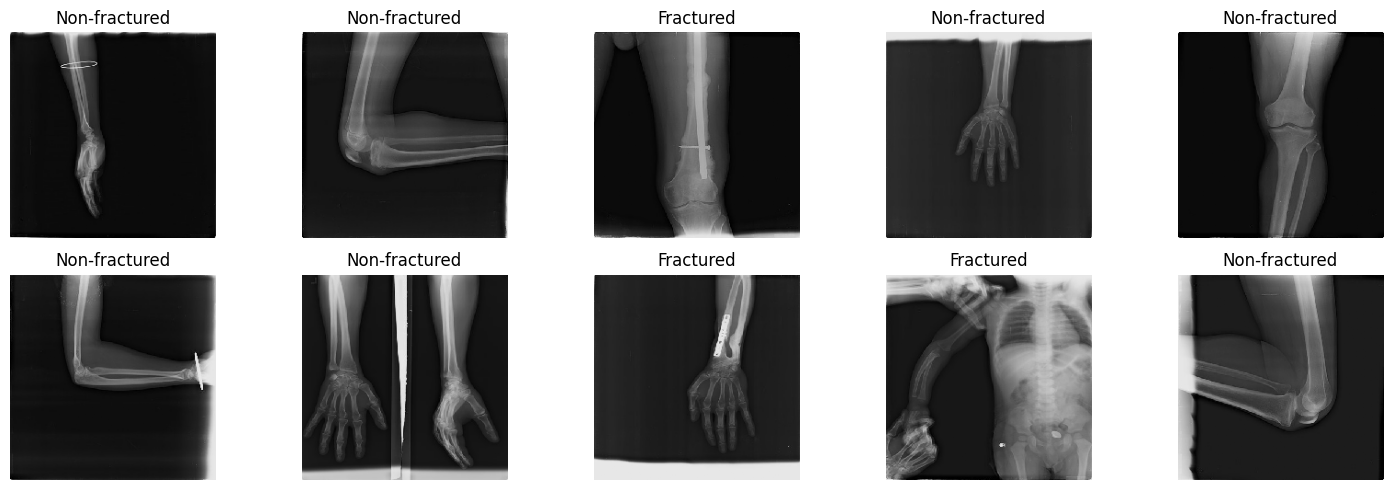

In [ ]:
plot_images(X_train, y_train, num_images=10)

In [ ]:
# Our general build EfficientNet model function, will be used throughout the notebook, whenever we want to instantiate a new EfficientNet backbone.
def build_efficientnet_model(
    num_classes: int = 1,
    use_imagenet: bool = True,
    input_shape: tuple = (224, 224, 3),
    dropout_rate: float = 0.5,
    fine_tune_at: int = None,
    base_trainable: bool = False,
    bn_trainable: bool = True,
    learning_rate: float = 1e-4
) -> tf.keras.Model:
    """
    This will returns an EfficientNetB0-based model.
    We include the following arguements
      num_classes: number of output classes.
      use_imagenet: whether to initialize with ImageNet weights (We will use this always).
      input_shape: model input size.
      dropout_rate: dropout after global pooling.
      fine_tune_at: layer index in base_model at which to start fine‑tuning.
      base_trainable: whether to train base_model layers.
      bn_trainable: whether BatchNormalization layers stay trainable.
      learning_rate: for the Adam optimizer.
    """
    # Base feature extractor
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet' if use_imagenet else None,
        input_shape=input_shape
    )
    # Optionally freeze base
    base.trainable = base_trainable
    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = bn_trainable

    # Head
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if dropout_rate:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)

    model = tf.keras.Model(inputs=base.input, outputs=outputs)

    # Fine‑tune last N layers (except batch‑norm)
    if fine_tune_at is not None:
        for layer in base.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base.layers[fine_tune_at:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=['accuracy']
    )
    return model

### EfficientNetB0 comprises 237 layers in total, We fine-tune only its final 37 layers.

In [ ]:
model_effnet = build_efficientnet_model(
    input_shape=(224, 224, 3),
    num_classes=1,
    dropout_rate=0.5,
    fine_tune_at=200,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-4
)

model_effnet.summary()


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "efficientnet_best.h5",
    save_best_only=True,
    monitor="val_loss"
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 2,051,985 (7.83 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

In [ ]:
history_eff_net = model_effnet.fit(
    X_train,y_train,
    validation_data = (X_val,y_val),
    batch_size =32,
    epochs = 50,
    callbacks = [checkpoint_cb,earlystop_cb],shuffle=True,
    verbose =1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8031 - loss: 0.5093

81/81 ━━━━━━━━━━━━━━━━━━━━ 88s 568ms/step - accuracy: 0.8033 - loss: 0.5091 - val_accuracy: 0.8214 - val_loss: 0.5511
Epoch 2/50
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8254 - loss: 0.4691

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8253 - loss: 0.4693 - val_accuracy: 0.8214 - val_loss: 0.5148
Epoch 3/50
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8253 - loss: 0.4769

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8252 - loss: 0.4770 - val_accuracy: 0.8214 - val_loss: 0.4928
Epoch 4/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8216 - loss: 0.4802

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8216 - loss: 0.4800 - val_accuracy: 0.8214 - val_loss: 0.4835
Epoch 5/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8096 - loss: 0.5041

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8100 - loss: 0.5031 - val_accuracy: 0.8214 - val_loss: 0.4687
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8268 - loss: 0.4771

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8267 - loss: 0.4771 - val_accuracy: 0.8214 - val_loss: 0.4680
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8279 - loss: 0.4597 - val_accuracy: 0.8214 - val_loss: 0.4723
Epoch 8/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8183 - loss: 0.4850

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8185 - loss: 0.4848 - val_accuracy: 0.8214 - val_loss: 0.4666
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8229 - loss: 0.4769 - val_accuracy: 0.8214 - val_loss: 0.4739
Epoch 10/50
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8116 - loss: 0.4941

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8119 - loss: 0.4937 - val_accuracy: 0.8214 - val_loss: 0.4664
Epoch 11/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8163 - loss: 0.4848

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8165 - loss: 0.4843 - val_accuracy: 0.8214 - val_loss: 0.4659
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8307 - loss: 0.4601 - val_accuracy: 0.8214 - val_loss: 0.4782
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8173 - loss: 0.4838 - val_accuracy: 0.8214 - val_loss: 0.4759
Epoch 14/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8303 - loss: 0.4646

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8300 - loss: 0.4651 - val_accuracy: 0.8214 - val_loss: 0.4658
Epoch 15/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8239 - loss: 0.4658

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8238 - loss: 0.4660 - val_accuracy: 0.8214 - val_loss: 0.4636
Epoch 16/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8304 - loss: 0.4604

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8301 - loss: 0.4608 - val_accuracy: 0.8214 - val_loss: 0.4635
Epoch 17/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8369 - loss: 0.4479 - val_accuracy: 0.8214 - val_loss: 0.4715
Epoch 18/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8217 - loss: 0.4761 - val_accuracy: 0.8214 - val_loss: 0.4716
Epoch 19/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8225 - loss: 0.4659 - val_accuracy: 0.8214 - val_loss: 0.4797


In [ ]:
test_loss, test_acc = model_effnet.evaluate(X_test, y_test, batch_size=32)
print(f"Test — loss: {test_loss:.4f}, acc: {test_acc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.8273 - loss: 0.4568
Test — loss: 0.4639, acc: 0.8224


### **Inception model for training the Classifier:**

In [ ]:
# Our general Inception model, will be used throughout the notebook, whenever we want to instantiate a new Inception backbone.
def build_inception_model(
    num_classes: int = 1,
    use_imagenet: bool = True,
    input_shape: tuple = (224, 224, 3),
    dropout_rate: float = 0.5,
    fine_tune_at: int = 249,
    base_trainable: bool = False,
    bn_trainable: bool = True,
    learning_rate: float = 1e-4
) -> tf.keras.Model:
    """
    Returns an InceptionV3-based model.

    Args:
      num_classes: number of output classes (1 for binary).
      use_imagenet: whether to initialize with ImageNet weights.
      input_shape: model input size.
      dropout_rate: dropout after global pooling.
      fine_tune_at: layer index in base_model at which to start fine‑tuning.
      base_trainable: whether to train base_model layers.
      bn_trainable: whether BatchNormalization layers stay trainable.
      learning_rate: for the Adam optimizer.

    """
    # Base feature extractor
    base = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet' if use_imagenet else None,
        input_shape=input_shape
    )
    # Optionally freeze base
    base.trainable = base_trainable
    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = bn_trainable

    # Head
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if dropout_rate:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)

    model = tf.keras.Model(inputs=base.input, outputs=outputs)

    # Fine‑tune last N layers (except batch‑norm)
    if fine_tune_at is not None:
        for layer in base.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base.layers[fine_tune_at:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=['accuracy']
    )
    return model

In [ ]:
# Build the model (to predict Fracture/ not fractured)
model_final_inception = build_inception_model(
    num_classes=1,
    use_imagenet=True,
    dropout_rate=0.5,
    fine_tune_at= len(tf.keras.applications.InceptionV3(include_top=False).layers) - 50,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-2
)

model_final_inception.summary()

# Prepare callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "inception_best.h5",
    save_best_only=True,
    monitor="val_loss"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 7,175,361 (27.37 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

In [ ]:
# Train
history = model_final_inception.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7973 - loss: 0.6716

81/81 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - accuracy: 0.7977 - loss: 0.6692 - val_accuracy: 0.8276 - val_loss: 2.6622
Epoch 2/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8858 - loss: 0.2835

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8860 - loss: 0.2831 - val_accuracy: 0.8602 - val_loss: 0.5846
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9207 - loss: 0.1988 - val_accuracy: 0.8447 - val_loss: 0.6894
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9331 - loss: 0.1696 - val_accuracy: 0.8727 - val_loss: 0.6782
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9514 - loss: 0.1316 - val_accuracy: 0.8494 - val_loss: 0.6457


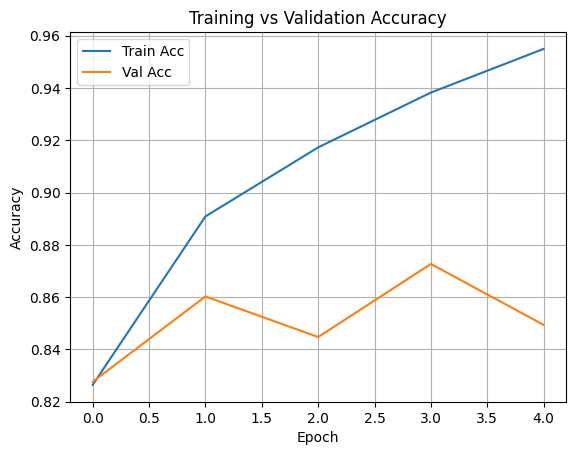

In [ ]:
# Training and Loss Curves
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate test set
test_loss, test_acc = model_final_inception.evaluate(X_test, y_test, batch_size=32)
print(f"Test   — loss: {test_loss:.4f}, acc: {test_acc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.8777 - loss: 0.4622
Test   — loss: 0.4779, acc: 0.8758


As we have an imbalanced dataset, overall accuracy can be misleading, instead we rely on the confusion matrix to compute class based accuracies.

Precision: out of those predicted fractured, how many are actually fractured.

Recall (Sensitivity): Out of those that are fractured, how many are predicted fractured.

Specificity: Out of those that are predicted Not fractured, how many are predicted not fractured.

To choose the decision threshold that best balances these measures, we analyze the ROC curve and select the point that maximizes the trade-off between sensitivity and specificity:

In [ ]:
y_prob = model_final_inception.predict(X_test, batch_size=32)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)

# Youden_index = sensitivity+specificity-1 (Method to determine optimal treshold, our method maximises tpr, and tnr together, which is the most imoortant)
youden_index = tpr-fpr
best_index = youden_index.argmax()
best_threshold = thresholds[best_index]

print(f"Best threshold: {best_threshold:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step
Best threshold: 0.1089


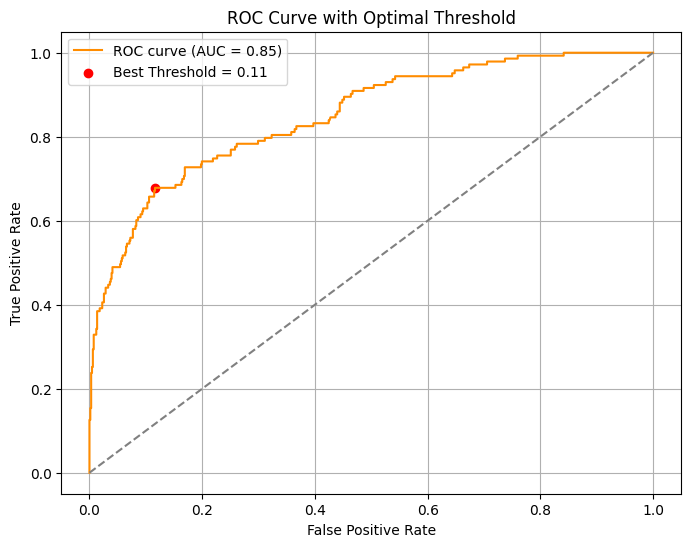

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[best_index], tpr[best_index], marker='o', color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Get predicted probabilities and threshold for 0.01, can try 0.01

y_pred = (y_prob >= best_threshold).astype(int).reshape(-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[585  77]
 [ 46  97]]


In [ ]:
# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

# Specificity calculation
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.5575
Recall (Sensitivity): 0.6783
Specificity: 0.8837
F1 Score: 0.6120
ROC AUC: 0.8494
Accuracy: 0.8472


# **Part 2:**
In the second part of this notebook, we focus on multiclass classification of bone fracture types using the Kaggle dataset.

We first report model performance on the unfiltered image set and then present the refined results obtained after applying the binary fracture/non-fracture detector to exclude images lacking clear fracture features.

We employ the InceptionV3 architecture to perform detailed fracture type classification:

Dataset with X-ray images that are fractured: Our new test set consists exclusively of images prefiltered by the binary fracture detector and therefore should all be true positives. For each image, we now predict one of the following ten fracture subtypes -

* Avulsion Fractures
* Comminuted Fractures
* Fracture Dislocations
* Greenstick Fractures
* Hairline Fractures
* Impacted fractures
* Longitudinal Fractures
* Oblique Fractures
* pathological fractures
* Spiral Fractures

https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset


### First without filteration or any augmentation:

In [ ]:
# Download and Prepare the Dataset
path = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")
path = os.path.join(path, 'Bone Break Classification/Bone Break Classification')

def collect_image_data_paths(directory):
    data = []
    # Scan each class folder
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        print(class_path)
        if os.path.isdir(class_path):
            for split in ['Train', 'Test']:
                split_path = os.path.join(class_path, split)
                if os.path.isdir(split_path):
                    for image_name in os.listdir(split_path):
                        image_path = os.path.join(split_path, image_name)
                        data.append({'path': image_path, 'target': class_folder, 'split': split})
    return data

# Collect the data and create a DataFrame
raw_data = collect_image_data_paths(path)
raw_df = pd.DataFrame(raw_data)

/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Spiral Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Impacted fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Greenstick fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Pathological fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Oblique fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Fracture Dislocation
/k

In [ ]:
# Make a copy
df=raw_df.copy()
# Turn class names into integer labels:
le= LabelEncoder()
df['target_encoded'] = le.fit_transform(df['target'])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# Split Data into Train, Validation, and Test
train_df_full = df[df['split'] == 'Train']
train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.1,
    random_state=42,
    stratify=train_df_full['target_encoded']
)
test_df = df[df['split'] == 'Test']

Classes: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [ ]:
# Load the images:
def load_images(df, size=(224, 224)):
    X = np.array([np.array(Image.open(p).resize(size).convert('RGB')) / 255.0 for p in df['path']])
    y = tf.keras.utils.to_categorical(df['target_encoded'], num_classes=num_classes)
    return X, y

X_train, y_train = load_images(train_df)
X_val, y_val = load_images(val_df)
X_test, y_test = load_images(test_df)

In [ ]:
X_train.shape

(890, 224, 224, 3)

In [ ]:
model_multiclass_basic_cnn= Sequential([
    # 1st convolutional block with batchnorm and dropout
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # 2nd convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # 3rd convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Fully connected layers with regularization
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_multiclass_basic_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_188 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_188         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_189 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_189         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_190         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_191         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_192 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_192         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_193 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_193         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_194         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,676,714 (197.13 MB)

 Trainable params: 51,674,794 (197.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model_multiclass_basic_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_basic_cnn = model_multiclass_basic_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    shuffle=True
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 475ms/step - accuracy: 0.1274 - loss: 3.4000 - val_accuracy: 0.1111 - val_loss: 2.8130
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3833 - loss: 1.8808 - val_accuracy: 0.1111 - val_loss: 4.2162
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4850 - loss: 1.5280 - val_accuracy: 0.1111 - val_loss: 5.7458
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5910 - loss: 1.2030 - val_accuracy: 0.1111 - val_loss: 6.2153
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7310 - loss: 0.8383 - val_accuracy: 0.1111 - val_loss: 5.9739
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8016 - loss: 0.6495 - val_accuracy: 0.1010 - val_loss: 3.8679
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8617 - loss: 0.4614 - val_accuracy: 0.0909 - val_loss: 3.8407
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9213 - loss: 0.3038 - val_accuracy: 0.1010 -

In [ ]:
test_loss, test_acc = model_multiclass_basic_cnn.evaluate(X_test, y_test)
print(f"Basic CNN - Test loss: {test_loss:.4f}, acc: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.3185 - loss: 3.5421
Basic CNN - Test loss: 3.9135, acc: 0.3071


Prediction on the Test Set

In [ ]:
y_pred_probs = model_multiclass_basic_cnn.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.3077    0.5714    0.4000        14
  Comminuted fracture     0.5000    0.2143    0.3000        14
 Fracture Dislocation     0.3103    0.4737    0.3750        19
  Greenstick fracture     0.2903    0.5625    0.3830        16
    Hairline Fracture     0.0000    0.0000    0.0000        10
    Impacted fracture     0.0952    0.2222    0.1333         9
Longitudinal fracture     0.2000    0.0833    0.1176        12
     Oblique fracture     0.6000    0.1875    0.2857        16
Pathological fracture     0.4615    0.3333    0.3871        18
      Spiral Fracture     1.0000    0.1667    0.2857        12

             accuracy                         0.3071       140
            macro avg     0.3765    0.2815    0.2667       140
         weighted avg     0.3930    0.3071    0.2902       140



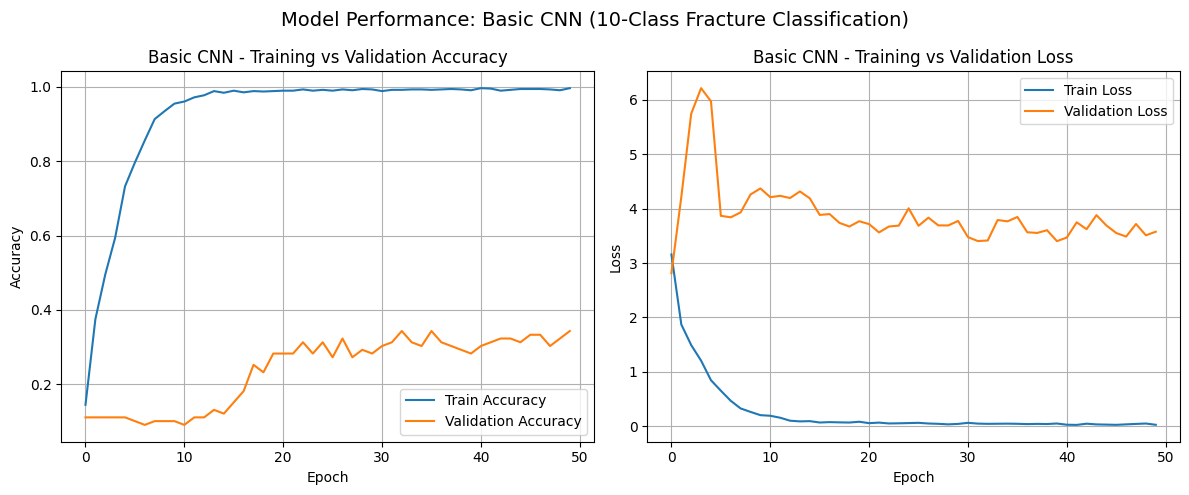

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_basic_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_basic_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Basic CNN - Training vs Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_basic_cnn.history['loss'], label='Train Loss')
plt.plot(history_basic_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Basic CNN - Training vs Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Super title for the whole figure
plt.suptitle('Model Performance: Basic CNN (10-Class Fracture Classification)', fontsize=14)
plt.tight_layout()
plt.show()

### EfficientNet Model

In [ ]:
model_effnet_multiclass = build_efficientnet_model(
    num_classes=10,
    use_imagenet=True,
    input_shape=(224, 224, 3),
    dropout_rate=0.5,
    fine_tune_at=200,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-4
)

model_effnet_multiclass.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "efficientnet_best.h5",
    save_best_only=True,
    monitor="val_loss"
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 2,063,514 (7.87 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

In [ ]:
history_effnet_multiclass = model_effnet_multiclass.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb],
    shuffle=True
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.1109 - loss: 2.3575

28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.1107 - loss: 2.3572 - val_accuracy: 0.1111 - val_loss: 2.3490
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1261 - loss: 2.3192 - val_accuracy: 0.1111 - val_loss: 2.3499
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1219 - loss: 2.3221

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1217 - loss: 2.3223 - val_accuracy: 0.1313 - val_loss: 2.3481
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0957 - loss: 2.3363 - val_accuracy: 0.1313 - val_loss: 2.3486
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1228 - loss: 2.2961

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1226 - loss: 2.2965 - val_accuracy: 0.1313 - val_loss: 2.3392
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1203 - loss: 2.3176

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1202 - loss: 2.3177 - val_accuracy: 0.1313 - val_loss: 2.3340
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1294 - loss: 2.3072

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1290 - loss: 2.3076 - val_accuracy: 0.1313 - val_loss: 2.3252
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1329 - loss: 2.2998

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1326 - loss: 2.3001 - val_accuracy: 0.1313 - val_loss: 2.3198
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1463 - loss: 2.3008

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1458 - loss: 2.3010 - val_accuracy: 0.1313 - val_loss: 2.3089
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1124 - loss: 2.3282

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1122 - loss: 2.3278 - val_accuracy: 0.1313 - val_loss: 2.3022
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1627 - loss: 2.2699

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1616 - loss: 2.2712 - val_accuracy: 0.1313 - val_loss: 2.3012
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1418 - loss: 2.3181

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1419 - loss: 2.3175 - val_accuracy: 0.1313 - val_loss: 2.2848
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1504 - loss: 2.2927

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1495 - loss: 2.2930 - val_accuracy: 0.1313 - val_loss: 2.2772
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1040 - loss: 2.3008 - val_accuracy: 0.1313 - val_loss: 2.2834
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1618 - loss: 2.2806 - val_accuracy: 0.1313 - val_loss: 2.2863
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1350 - loss: 2.3098

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1348 - loss: 2.3098 - val_accuracy: 0.1313 - val_loss: 2.2769
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1085 - loss: 2.3003

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1089 - loss: 2.3001 - val_accuracy: 0.1313 - val_loss: 2.2705
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1391 - loss: 2.2943 - val_accuracy: 0.1313 - val_loss: 2.2815
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1138 - loss: 2.3000 - val_accuracy: 0.1313 - val_loss: 2.2878
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1333 - loss: 2.3093 - val_accuracy: 0.1313 - val_loss: 2.2707


In [ ]:
test_loss, test_acc = model_effnet_multiclass.evaluate(X_test, y_test)
print(f"EfficientNetB0 — Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.0288 - loss: 2.3506
EfficientNetB0 — Test loss: 2.3027, Test acc: 0.0786


In [ ]:
y_pred_probs = model_effnet_multiclass.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

1/5 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.0000    0.0000    0.0000        14
  Comminuted fracture     0.0833    0.7857    0.1507        14
 Fracture Dislocation     0.0000    0.0000    0.0000        19
  Greenstick fracture     0.0000    0.0000    0.0000        16
    Hairline Fracture     0.0000    0.0000    0.0000        10
    Impacted fracture     0.0000    0.0000    0.0000         9
Longitudinal fracture     0.0000    0.0000    0.0000        12
     Oblique fracture     0.0000    0.0000    0.0000        16
Pathological fracture     0.0000    0.0000    0.0000        18
      Spiral Fracture     0.0000    0.0000    0.0000        12

             accuracy                         0.0786       140
            macro avg     0.0083    0.0786    0.0151       140
         weighted avg     0.0083    0.0786    0.0151       140



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


EfficientNet was even worse.

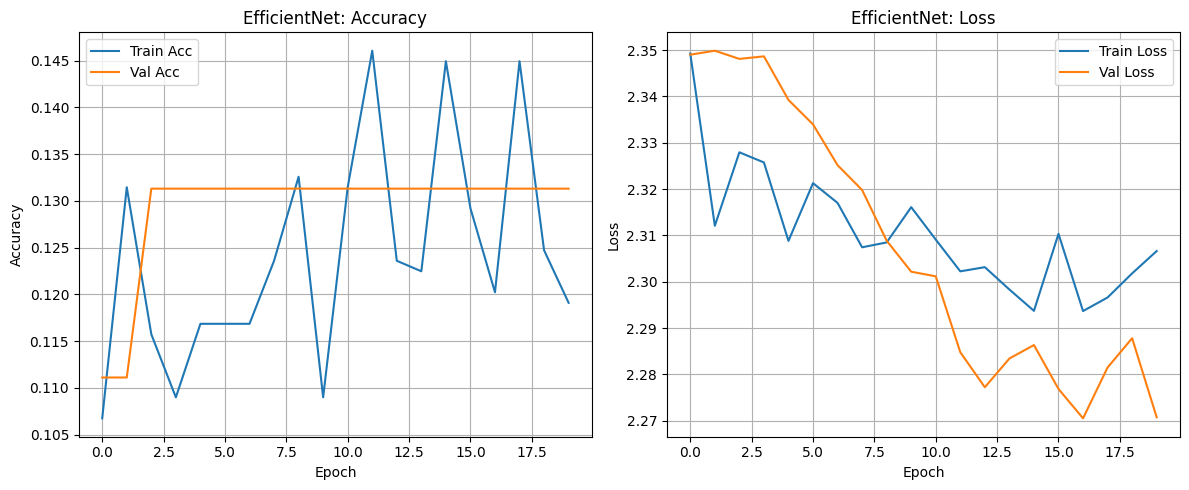

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_effnet_multiclass.history['accuracy'], label='Train Acc')
plt.plot(history_effnet_multiclass.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNet: Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_effnet_multiclass.history['loss'], label='Train Loss')
plt.plot(history_effnet_multiclass.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNet: Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Now for the Inception Model:


In [ ]:
model_multiclass_inception = build_inception_model(
    num_classes=num_classes,
    use_imagenet=True,
    dropout_rate=0.5,
    fine_tune_at=len(tf.keras.applications.InceptionV3(include_top=False).layers) - 50,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-4
)

# 2. Prepare callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "inception_best.h5",
    save_best_only=True,
    monitor="val_loss"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [ ]:
history_multiclass_inception = model_multiclass_inception.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb],
    shuffle=True
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.1277 - loss: 2.3905

28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.1291 - loss: 2.3876 - val_accuracy: 0.3232 - val_loss: 2.0819
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5384 - loss: 1.4896

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5390 - loss: 1.4871 - val_accuracy: 0.4242 - val_loss: 1.8866
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7893 - loss: 0.8673

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7898 - loss: 0.8655 - val_accuracy: 0.4747 - val_loss: 1.7470
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9192 - loss: 0.4834

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9196 - loss: 0.4825 - val_accuracy: 0.5051 - val_loss: 1.6886
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9814 - loss: 0.2691

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9816 - loss: 0.2683 - val_accuracy: 0.4747 - val_loss: 1.6543
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9979 - loss: 0.1502

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9977 - loss: 0.1502 - val_accuracy: 0.5051 - val_loss: 1.6170
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9988 - loss: 0.0917

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9987 - loss: 0.0919 - val_accuracy: 0.5051 - val_loss: 1.6055
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9986 - loss: 0.0745 - val_accuracy: 0.5152 - val_loss: 1.6146
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9979 - loss: 0.0471 - val_accuracy: 0.5253 - val_loss: 1.6131
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9991 - loss: 0.0380

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9990 - loss: 0.0382 - val_accuracy: 0.5354 - val_loss: 1.6011
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9986 - loss: 0.0325

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9985 - loss: 0.0325 - val_accuracy: 0.5556 - val_loss: 1.5930
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9985 - loss: 0.0281 - val_accuracy: 0.5556 - val_loss: 1.6014
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9982 - loss: 0.0222

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9981 - loss: 0.0223 - val_accuracy: 0.5455 - val_loss: 1.5914
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9992 - loss: 0.0190 - val_accuracy: 0.5455 - val_loss: 1.5951
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.5253 - val_loss: 1.5987
Epoch 16/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9984 - loss: 0.0176 - val_accuracy: 0.5556 - val_loss: 1.5957


In [ ]:
test_loss, test_acc = model_multiclass_inception.evaluate(X_test, y_test)
print(f"InceptionV3 - Test loss: {test_loss:.4f}, acc: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4022 - loss: 1.9835
InceptionV3 - Test loss: 2.0191, acc: 0.3929


In [ ]:
y_pred_probs = model_multiclass_inception.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.3810    0.5714    0.4571        14
  Comminuted fracture     0.4091    0.6429    0.5000        14
 Fracture Dislocation     0.5000    0.4211    0.4571        19
  Greenstick fracture     0.4444    0.5000    0.4706        16
    Hairline Fracture     0.3077    0.4000    0.3478        10
    Impacted fracture     0.2500    0.3333    0.2857         9
Longitudinal fracture     0.2500    0.1667    0.2000        12
     Oblique fracture     0.6000    0.1875    0.2857        16
Pathological fracture     0.4000    0.3333    0.3636        18
      Spiral Fracture     0.4000    0.3333    0.3636        12

             accuracy                         0.3929       140
            macro avg     0.3942    0.3890    0.3731       140
         weighted avg     0.4114    0.3929    0.3825       140



### All 10 Bone Fracture Classes with Augmentation:


In [ ]:
from matplotlib import cm

def apply_color_map(ct_image, cmap='jet'):
    norm = (ct_image - np.min(ct_image)) / ((np.max(ct_image) - np.min(ct_image)) + 1e-7)
    colored = plt.cm.get_cmap(cmap)(norm)
    return (colored[:, :, :3] * 255).astype(np.uint8)

def apply_adaptive_hist_eq(ct_image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(ct_image)
    return apply_color_map(enhanced, 'jet')

def apply_contrast_stretching(ct_image):
    min_val, max_val = np.min(ct_image), np.max(ct_image)
    stretched = (ct_image - min_val) / ((max_val - min_val) + 1e-7)
    return apply_color_map(stretched, 'jet')

def apply_gaussian_blur(ct_image):
    blurred = cv2.GaussianBlur(ct_image, (5, 5), 0)
    return apply_color_map(blurred, 'jet')

def apply_gamma_correction(ct_image, gamma=1.2):
    ct_float = ct_image.astype(np.float32)
    gamma_corr = np.power(ct_float / (np.max(ct_float) + 1e-7), gamma) * 255
    return apply_color_map(gamma_corr, 'jet')

def apply_lut_color_map(ct_image):
    return apply_color_map(ct_image, cmap='plasma')

def apply_alpha_blending(ct_image):
    thresholded = ct_image > 100
    colored = apply_color_map(ct_image, 'jet')
    mask = (thresholded.astype(np.uint8)) * 255
    mask_rgb = np.stack([mask, mask, mask], axis=-1)
    alpha = 0.5
    blended = alpha * colored + (1 - alpha) * mask_rgb
    return blended.astype(np.uint8)

def apply_3d_rendering(ct_image):
    return apply_color_map(ct_image, 'jet')

def apply_heatmap(ct_image):
    norm = (ct_image - np.min(ct_image)) / ((np.max(ct_image) - np.min(ct_image)) + 1e-7)
    heatmap = cm.hot(norm)
    return (heatmap[:, :, :3] * 255).astype(np.uint8)

def apply_3d_volume_rendering(ct_image):
    return apply_color_map(ct_image, 'jet')


# Define Additional Augmentation Functions for X‑ray Data (5 Variations)
def apply_rotation(ct_image, angle=5):
    (h, w) = ct_image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(ct_image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return apply_color_map(rotated, 'jet')

def apply_translation(ct_image, tx=5, ty=5):
    (h, w) = ct_image.shape
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(ct_image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return apply_color_map(translated, 'jet')

def apply_brightness_contrast(ct_image, brightness=30, contrast=1.2):
    adjusted = ct_image.astype(np.float32) * contrast + brightness
    adjusted = np.clip(adjusted, 0, 255).astype(np.uint8)
    return apply_color_map(adjusted, 'jet')

def apply_gaussian_noise(ct_image, mean=0, sigma=10):
    noise = np.random.normal(mean, sigma, ct_image.shape)
    noisy = ct_image.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return apply_color_map(noisy, 'jet')

def apply_zoom(ct_image, scale=1.1):
    (h, w) = ct_image.shape
    new_h, new_w = int(h / scale), int(w / scale)
    start_row = (h - new_h) // 2
    start_col = (w - new_w) // 2
    cropped = ct_image[start_row:start_row + new_h, start_col:start_col + new_w]
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return apply_color_map(zoomed, 'jet')


# Combine All Augmentation Functions, Original 10 variations + 5 additional variations

augmentation_functions = [
 apply_color_map,
   apply_adaptive_hist_eq,
   apply_contrast_stretching,
    apply_gaussian_blur,
    apply_gamma_correction,
    apply_lut_color_map,
    apply_alpha_blending,
    apply_3d_rendering,
    apply_heatmap,
    apply_3d_volume_rendering,
    apply_rotation,
    apply_translation,
    apply_brightness_contrast,
    apply_gaussian_noise,
    apply_zoom
]


# Utility Function to Load and Resize an Image
def load_image(img_path, target_size=(256, 256)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    return np.array(img)


# Custom Training Generator: Expand Each Image
def multi_augment_generator(df, batch_size, target_size=(256, 256), k=5):
    import random
    import numpy as np
    import cv2

    image_paths = df['path'].tolist()
    labels = df['target_encoded'].tolist()

    while True:
        batch_images = []
        batch_labels = []

        for path, label in zip(image_paths, labels):
            # Load and preprocess the original image
            original = load_image(path, target_size)
            normalized = original.astype(np.float32) / 255.0

            # Add the original image
            batch_images.append(normalized)
            batch_labels.append(label)  # <-- integer label

            # Convert to grayscale for augmentation
            gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)

            # Apply k random augmentations
            for func in random.sample(augmentation_functions, k=k):
                aug_img = func(gray).astype(np.float32) / 255.0
                batch_images.append(aug_img)
                batch_labels.append(label)  # <-- integer label

            # Yield complete batches
            while len(batch_images) >= batch_size:
                yield (
                    np.array(batch_images[:batch_size]),
                    np.array(batch_labels[:batch_size])
                )
                batch_images = batch_images[batch_size:]
                batch_labels = batch_labels[batch_size:]

        # Yield remainder at end of epoch
        if batch_images:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images, batch_labels = [], []

# Create Validation and Test Generators Using ImageDataGenerator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 10
img_height = 224
img_width = 224

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='target_encoded',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='target_encoded',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)


# Configure the Training Generator and Steps per Epoch
# Each original image is expanded to 1 original + 15 augmented variations = 16 samples.
steps_per_epoch = int(np.ceil(len(train_df) * 16 / batch_size))
train_generator = multi_augment_generator(train_df, batch_size, target_size=(img_height, img_width))

# Print
print(f"Original training samples: {len(train_df)}")
print(f"Effective training samples (with augmentation): {len(train_df) * 16}")
print("\nTrain samples per class:")
print(train_df['target'].value_counts())
print("\nValidation samples per class:")
print(val_df['target'].value_counts())
print("\nTest samples per class:")
print(test_df['target'].value_counts())

class_idx_to_name = {i: name for i, name in enumerate(le.classes_)}
print(f"Class index to name mapping: {class_idx_to_name}")

Found 99 validated image filenames.
Found 140 validated image filenames.
Original training samples: 890
Effective training samples (with augmentation): 14240

Train samples per class:
target
Fracture Dislocation     123
Comminuted fracture      121
Pathological fracture    104
Avulsion fracture         98
Greenstick fracture       95
Hairline Fracture         91
Impacted fracture         68
Spiral Fracture           67
Oblique fracture          62
Longitudinal fracture     61
Name: count, dtype: int64

Validation samples per class:
target
Fracture Dislocation     14
Comminuted fracture      13
Pathological fracture    12
Avulsion fracture        11
Greenstick fracture      11
Hairline Fracture        10
Spiral Fracture           7
Longitudinal fracture     7
Oblique fracture          7
Impacted fracture         7
Name: count, dtype: int64

Test samples per class:
target
Fracture Dislocation     19
Pathological fracture    18
Oblique fracture         16
Greenstick fracture      16
Commi

### Basic CNN Model with Augmentation

In [ ]:
model_multiclass_basic_cnn_with_aug= Sequential([
    # 1st convolutional block with batchnorm and dropout
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # 2nd convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # 3rd convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Fully connected layers with regularization
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_multiclass_basic_cnn_with_aug.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_382 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_383         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_383 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_384         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_384 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_385         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_385 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_386         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_386 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_387         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_387 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_388         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_389         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,676,714 (197.13 MB)

 Trainable params: 51,674,794 (197.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Compile
model_multiclass_basic_cnn_with_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Train
history_multiclass_basic_cnn_with_aug = model_multiclass_basic_cnn_with_aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, earlystop_cb],
    epochs=50
)
# Evaluate
test_loss, test_acc = model_multiclass_basic_cnn_with_aug.evaluate(test_generator)
print(f"Basic CNN - Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

<ipython-input-45-0dfb05c94c37>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = plt.cm.get_cmap(cmap)(norm)


Epoch 1/50
1423/1424 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1503 - loss: 2.5690

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1424/1424 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.1504 - loss: 2.5687 - val_accuracy: 0.1212 - val_loss: 6.5017
Epoch 2/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - accuracy: 0.3947 - loss: 1.8603 - val_accuracy: 0.2020 - val_loss: 2.7475
Epoch 3/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.6070 - loss: 1.2677 - val_accuracy: 0.2727 - val_loss: 3.0285
Epoch 4/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - accuracy: 0.7667 - loss: 0.8148 - val_accuracy: 0.2121 - val_loss: 5.9944
Epoch 5/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.8313 - loss: 0.6139 - val_accuracy: 0.2525 - val_loss: 3.6844
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1857 - loss: 2.7425
Basic CNN - Test loss: 2.8153, Test acc: 0.1786


In [ ]:
y_pred_probs = model_multiclass_basic_cnn_with_aug.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.3636    0.2857    0.3200        14
  Comminuted fracture     0.1111    0.2143    0.1463        14
 Fracture Dislocation     0.2105    0.2105    0.2105        19
  Greenstick fracture     0.2105    0.2500    0.2286        16
    Hairline Fracture     0.0000    0.0000    0.0000        10
    Impacted fracture     0.0417    0.1111    0.0606         9
Longitudinal fracture     0.0000    0.0000    0.0000        12
     Oblique fracture     0.2308    0.1875    0.2069        16
Pathological fracture     0.5714    0.2222    0.3200        18
      Spiral Fracture     0.0000    0.0000    0.0000        12

             accuracy                         0.1643       140
            macro avg     0.1740    0.1481    0.1493       140
         weighted avg     0.2026    0.1643    0.1700       140



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###  Now for the Inception Model with Augmentation:

In [ ]:
#  Define
model_inception_multiclass_with_aug = build_inception_model(
    num_classes=len(le.classes_),
    use_imagenet=True,
    input_shape=(img_height, img_width, 3),
    dropout_rate=0.5,
    fine_tune_at=len(tf.keras.applications.InceptionV3(include_top=False).layers) - 50,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-4
)

# Compile
model_inception_multiclass_with_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "inception_best.h5",
    save_best_only=True,
    monitor="val_loss"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Train
history_inception_multiclass_with_aug = model_inception_multiclass_with_aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/50


<ipython-input-45-0dfb05c94c37>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = plt.cm.get_cmap(cmap)(norm)


1424/1424 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2196 - loss: 2.2206

1424/1424 ━━━━━━━━━━━━━━━━━━━━ 90s 46ms/step - accuracy: 0.2197 - loss: 2.2204 - val_accuracy: 0.3838 - val_loss: 2.1246
Epoch 2/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.7360 - loss: 0.9234 - val_accuracy: 0.3838 - val_loss: 2.4373
Epoch 3/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.9086 - loss: 0.3853 - val_accuracy: 0.4040 - val_loss: 2.7678
Epoch 4/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.9522 - loss: 0.2162 - val_accuracy: 0.4040 - val_loss: 2.5099


In [ ]:
test_loss, test_acc = model_inception_multiclass_with_aug.evaluate(test_generator)
print(f"InceptionV3 - Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3124 - loss: 2.2690
InceptionV3 - Test loss: 2.3601, Test acc: 0.2857


In [ ]:
y_pred_probs = model_inception_multiclass_with_aug.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.3333    0.7857    0.4681        14
  Comminuted fracture     0.3000    0.2143    0.2500        14
 Fracture Dislocation     0.2000    0.2105    0.2051        19
  Greenstick fracture     0.5385    0.4375    0.4828        16
    Hairline Fracture     0.0000    0.0000    0.0000        10
    Impacted fracture     0.1667    0.1111    0.1333         9
Longitudinal fracture     0.1333    0.1667    0.1481        12
     Oblique fracture     0.4000    0.1250    0.1905        16
Pathological fracture     0.5714    0.4444    0.5000        18
      Spiral Fracture     0.2174    0.4167    0.2857        12

             accuracy                         0.3071       140
            macro avg     0.2861    0.2912    0.2664       140
         weighted avg     0.3120    0.3071    0.2866       140



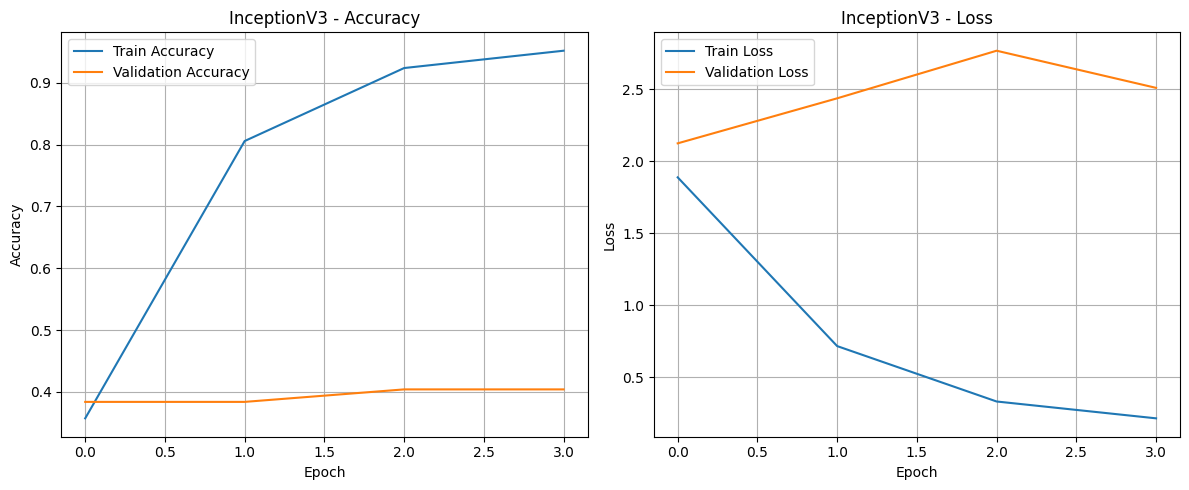

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_inception_multiclass_with_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_inception_multiclass_with_aug.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('InceptionV3 - Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_inception_multiclass_with_aug.history['loss'], label='Train Loss')
plt.plot(history_inception_multiclass_with_aug.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('InceptionV3 - Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### EfficientNet Model with Augmentation

In [ ]:
# Define
model_effnet_multiclass_with_Aug = build_efficientnet_model(
    num_classes=len(le.classes_),  # e.g., 10
    use_imagenet=True,
    input_shape=(img_height, img_width, 3),
    dropout_rate=0.5,
    fine_tune_at=200,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-4
)

# Compile
model_effnet_multiclass_with_Aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


# Train
history_effnet_multiclass_with_aug = model_effnet_multiclass_with_Aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/50


<ipython-input-45-0dfb05c94c37>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = plt.cm.get_cmap(cmap)(norm)


1424/1424 ━━━━━━━━━━━━━━━━━━━━ 110s 49ms/step - accuracy: 0.1180 - loss: 2.3339 - val_accuracy: 0.1414 - val_loss: 2.2761
Epoch 2/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.1257 - loss: 2.3017 - val_accuracy: 0.1313 - val_loss: 2.2742
Epoch 3/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.1172 - loss: 2.3026 - val_accuracy: 0.1414 - val_loss: 2.2817
Epoch 4/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.1187 - loss: 2.2908 - val_accuracy: 0.1414 - val_loss: 2.2836
Epoch 5/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.1304 - loss: 2.2899 - val_accuracy: 0.1414 - val_loss: 2.2709
Epoch 6/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.1264 - loss: 2.2921 - val_accuracy: 0.1414 - val_loss: 2.2745
Epoch 7/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.1217 - loss: 2.2822 - val_accuracy: 0.2121 - val_loss: 2.2785
Epoch 8/50
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.1239 - loss: 2.2

In [ ]:
test_loss, test_acc = model_effnet_multiclass_with_Aug.evaluate(test_generator)
print(f"EfficientNetB0 - Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1396 - loss: 2.3247
EfficientNetB0 - Test loss: 2.3057, Test acc: 0.1357


In [ ]:
y_pred_probs = model_effnet_multiclass_with_Aug.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.0000    0.0000    0.0000        14
  Comminuted fracture     0.0000    0.0000    0.0000        14
 Fracture Dislocation     0.1357    1.0000    0.2390        19
  Greenstick fracture     0.0000    0.0000    0.0000        16
    Hairline Fracture     0.0000    0.0000    0.0000        10
    Impacted fracture     0.0000    0.0000    0.0000         9
Longitudinal fracture     0.0000    0.0000    0.0000        12
     Oblique fracture     0.0000    0.0000    0.0000        16
Pathological fracture     0.0000    0.0000    0.0000        18
      Spiral Fracture     0.0000    0.0000    0.0000        12

             accuracy                         0.1357       140
            macro avg     0.0136    0.1000    0.0239       140
         weighted avg     0.0184    0.1357    0.0324       140



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


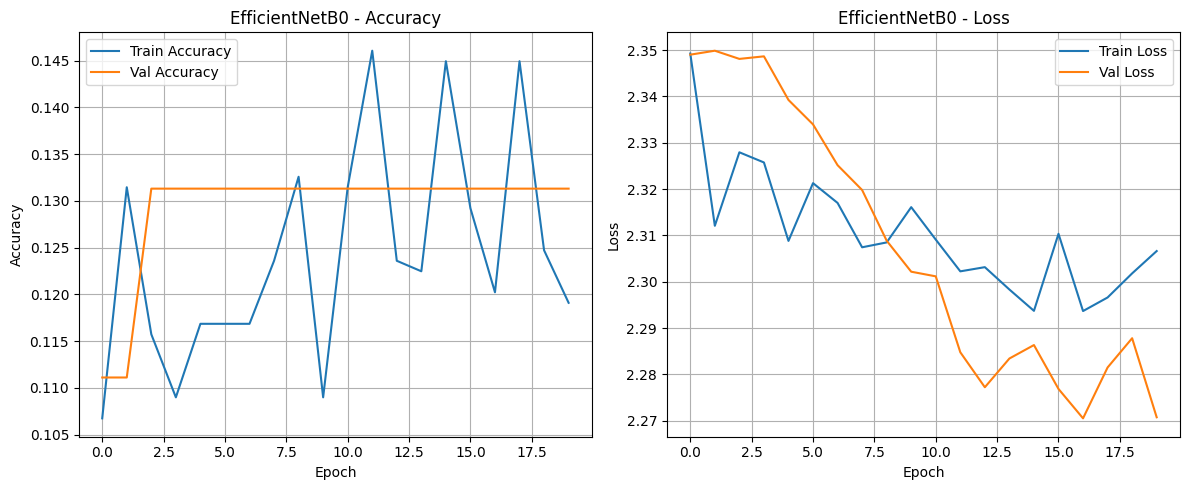

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_effnet_multiclass.history['accuracy'], label='Train Accuracy')
plt.plot(history_effnet_multiclass.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNetB0 - Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_effnet_multiclass.history['loss'], label='Train Loss')
plt.plot(history_effnet_multiclass.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNetB0 - Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Now, we train on the fracture filtered dataset augmented with a diverse set of image transformations on all the 10 classes:


Filtered and Augmented with all 10 classes

In [ ]:
# Load all images
X = np.array([np.array(Image.open(p).resize((224, 224)).convert('RGB')) / 255.0 for p in raw_df['path']])
y = np.array(raw_df['target'].tolist())

# Predict fractures
fracture_preds = model_final_inception.predict(X, batch_size=32)
fracture_preds = (fracture_preds > 0.01).astype(int).flatten()

# We select a very low treshold of 0.01, as we know that these images should all theoretically be captured as Fractured.

# Filter only fractured images
df = raw_df[fracture_preds == 1].reset_index(drop=True)


# Split Data into Train, Validation, and Test
train_df_full = df[df['split'] == 'Train']
train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.1,
    random_state=42,
    stratify=train_df_full['target']
)
test_df = df[df['split'] == 'Test']

# Define Original Augmentation Functions (10 Variations) (These were taken from )
def apply_color_map(ct_image, cmap='jet'):
    # Normalize avoiding divide-by-zero and apply colormap
    norm = (ct_image - np.min(ct_image)) / ((np.max(ct_image) - np.min(ct_image)) + 1e-7)
    colored = cm.get_cmap(cmap)(norm)
    return (colored[:, :, :3] * 255).astype(np.uint8)

def apply_adaptive_hist_eq(ct_image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(ct_image)
    return apply_color_map(enhanced, 'jet')

def apply_contrast_stretching(ct_image):
    min_val, max_val = np.min(ct_image), np.max(ct_image)
    stretched = (ct_image - min_val) / ((max_val - min_val) + 1e-7)
    return apply_color_map(stretched, 'jet')

def apply_gaussian_blur(ct_image):
    blurred = cv2.GaussianBlur(ct_image, (5, 5), 0)
    return apply_color_map(blurred, 'jet')

def apply_gamma_correction(ct_image, gamma=1.2):
    ct_float = ct_image.astype(np.float32)
    gamma_corr = np.power(ct_float / (np.max(ct_float) + 1e-7), gamma) * 255
    return apply_color_map(gamma_corr, 'jet')

def apply_lut_color_map(ct_image):
    return apply_color_map(ct_image, cmap='plasma')

def apply_alpha_blending(ct_image):
    thresholded = ct_image > 100
    colored = apply_color_map(ct_image, 'jet')
    mask = (thresholded.astype(np.uint8)) * 255
    mask_rgb = np.stack([mask, mask, mask], axis=-1)
    alpha = 0.5
    blended = alpha * colored + (1 - alpha) * mask_rgb
    return blended.astype(np.uint8)

def apply_3d_rendering(ct_image):
    return apply_color_map(ct_image, 'jet')

def apply_heatmap(ct_image):
    norm = (ct_image - np.min(ct_image)) / ((np.max(ct_image) - np.min(ct_image)) + 1e-7)
    heatmap = cm.hot(norm)
    return (heatmap[:, :, :3] * 255).astype(np.uint8)

def apply_3d_volume_rendering(ct_image):
    return apply_color_map(ct_image, 'jet')

# Define Additional Augmentation Functions for X‑ray Data (5 Variations)
def apply_rotation(ct_image, angle=5):
    (h, w) = ct_image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(ct_image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return apply_color_map(rotated, 'jet')

def apply_translation(ct_image, tx=5, ty=5):
    (h, w) = ct_image.shape
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(ct_image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return apply_color_map(translated, 'jet')

def apply_brightness_contrast(ct_image, brightness=30, contrast=1.2):
    adjusted = ct_image.astype(np.float32) * contrast + brightness
    adjusted = np.clip(adjusted, 0, 255).astype(np.uint8)
    return apply_color_map(adjusted, 'jet')

def apply_gaussian_noise(ct_image, mean=0, sigma=10):
    noise = np.random.normal(mean, sigma, ct_image.shape)
    noisy = ct_image.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return apply_color_map(noisy, 'jet')

def apply_zoom(ct_image, scale=1.1):
    (h, w) = ct_image.shape
    new_h, new_w = int(h / scale), int(w / scale)
    start_row = (h - new_h) // 2
    start_col = (w - new_w) // 2
    cropped = ct_image[start_row:start_row + new_h, start_col:start_col + new_w]
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return apply_color_map(zoomed, 'jet')


# Combine All Augmentation Functions, Original 10 variations + 5 additional variations

augmentation_functions = [
 apply_color_map,
   apply_adaptive_hist_eq,
   apply_contrast_stretching,
    apply_gaussian_blur,
    apply_gamma_correction,
    apply_lut_color_map,
    apply_alpha_blending,
    apply_3d_rendering,
    apply_heatmap,
    apply_3d_volume_rendering,
    apply_rotation,
    apply_translation,
    apply_brightness_contrast,
    apply_gaussian_noise,
    apply_zoom
]


# Utility Function to Load and Resize an Image
def load_image(img_path, target_size=(256, 256)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    return np.array(img)

# Custom Training Generator: Expand Each Image
def multi_augment_generator(df, batch_size, target_size=(256, 256), k=5):
    image_paths = df['path'].tolist()
    labels = df['target'].tolist()
    classes = sorted(df['target'].unique())
    class_indices = {c: i for i, c in enumerate(classes)}
    num_classes = len(classes)

    while True:
        batch_images = []
        batch_labels = []

        for path, label in zip(image_paths, labels):
            # Load and preprocess the original image
            original = load_image(path, target_size)
            normalized = original.astype(np.float32) / 255.0
            one_hot = np.zeros(num_classes, dtype=np.float32)
            one_hot[class_indices[label]] = 1.0

            # Add the original image
            batch_images.append(normalized)
            batch_labels.append(one_hot)

            # Convert to grayscale for augmentation
            gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)

            # Apply k random augmentations
            for func in random.sample(augmentation_functions, k=k):
                aug_img = func(gray).astype(np.float32) / 255.0
                batch_images.append(aug_img)
                batch_labels.append(one_hot)

            # Yield complete batches
            while len(batch_images) >= batch_size:
                yield (np.array(batch_images[:batch_size]), np.array(batch_labels[:batch_size]))
                batch_images = batch_images[batch_size:]
                batch_labels = batch_labels[batch_size:]

        # Yield remainder at end of epoch
        if batch_images:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images, batch_labels = [], []

# Create Validation and Test Generators Using ImageDataGenerator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 10
img_height = 224
img_width = 224

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Configure the Training Generator and Steps per Epoch
# Each original image is expanded to 1 original + 15 augmented variations = 16 samples.
steps_per_epoch = int(np.ceil(len(train_df) * 16 / batch_size))
train_generator = multi_augment_generator(train_df, batch_size, target_size=(img_height, img_width))

# Print Statistics
print(f"Original training samples: {len(train_df)}")
print(f"Effective training samples (with augmentation): {len(train_df) * 16}")
print("\nTrain samples per class:")
print(train_df['target'].value_counts())
print("\nValidation samples per class:")
print(val_df['target'].value_counts())
print("\nTest samples per class:")
print(test_df['target'].value_counts())

class_idx_to_name = {v: k for k, v in val_generator.class_indices.items()}
print(f"Class index to name mapping: {class_idx_to_name}")
print(f"Validation class indices: {val_generator.class_indices}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step
Found 85 validated image filenames belonging to 10 classes.
Found 118 validated image filenames belonging to 10 classes.
Original training samples: 763
Effective training samples (with augmentation): 12208

Train samples per class:
target
Fracture Dislocation     111
Comminuted fracture      106
Pathological fracture     94
Greenstick fracture       85
Hairline Fracture         74
Avulsion fracture         66
Oblique fracture          60
Spiral Fracture           60
Longitudinal fracture     56
Impacted fracture         51
Name: count, dtype: int64

Validation samples per class:
target
Fracture Dislocation     12
Comminuted fracture      12
Pathological fracture    10
Greenstick fracture      10
Hairline Fracture         8
Avulsion fracture         7
Oblique fracture          7
Spiral Fracture           7
Impacted fracture         6
Longitudinal fracture     6
Name: count, dtype: int64

Test samples per class:
target
Fracture Dislocation     17


Basic CNN Filtered and with Augmentation

In [ ]:
model_multiclass_basic_cnn_filtered_with_aug= Sequential([
    # 1st convolutional block with batchnorm and dropout
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # 2nd convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # 3rd convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Fully connected layers with regularization
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_multiclass_basic_cnn_filtered_with_aug.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_576 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_578         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_577 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_579         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_578 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_580         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_579 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_581         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_580 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_582         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_581 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_583         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_584         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,676,714 (197.13 MB)

 Trainable params: 51,674,794 (197.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Compile
model_multiclass_basic_cnn_filtered_with_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Train
history_multiclass_basic_cnn_filtered_with_aug = model_multiclass_basic_cnn_filtered_with_aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, earlystop_cb],
    epochs=50
)
# Evaluate
test_loss, test_acc = model_multiclass_basic_cnn_filtered_with_aug.evaluate(test_generator)
print(f"Basic CNN - Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

<ipython-input-57-d6d9567f0a23>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = cm.get_cmap(cmap)(norm)


Epoch 1/50
1220/1221 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1687 - loss: 2.5803

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1221/1221 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - accuracy: 0.1688 - loss: 2.5800 - val_accuracy: 0.0941 - val_loss: 22.6372
Epoch 2/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.3487 - loss: 2.0127 - val_accuracy: 0.1765 - val_loss: 6.0393
Epoch 3/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.5281 - loss: 1.5267 - val_accuracy: 0.2235 - val_loss: 3.0584
Epoch 4/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.7033 - loss: 0.9968 - val_accuracy: 0.2471 - val_loss: 4.0765
Epoch 5/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8108 - loss: 0.6601 - val_accuracy: 0.2118 - val_loss: 3.1937
Epoch 6/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8436 - loss: 0.5654 - val_accuracy: 0.2588 - val_loss: 4.0246
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.1267 - loss: 3.5685
Basic CNN - Test loss: 3.4452, Test acc: 0.1864


In [ ]:
y_pred_probs = model_multiclass_basic_cnn_filtered_with_aug.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.0968    0.2143    0.1333        14
  Comminuted fracture     0.3333    0.2857    0.3077        14
 Fracture Dislocation     0.5000    0.2105    0.2963        19
  Greenstick fracture     0.1538    0.1250    0.1379        16
    Hairline Fracture     0.0000    0.0000    0.0000        10
    Impacted fracture     0.0000    0.0000    0.0000         9
Longitudinal fracture     0.1500    0.5000    0.2308        12
     Oblique fracture     0.0000    0.0000    0.0000        16
Pathological fracture     0.2308    0.1667    0.1935        18
      Spiral Fracture     0.5000    0.1667    0.2500        12

             accuracy                         0.1714       140
            macro avg     0.1965    0.1669    0.1550       140
         weighted avg     0.2138    0.1714    0.1662       140



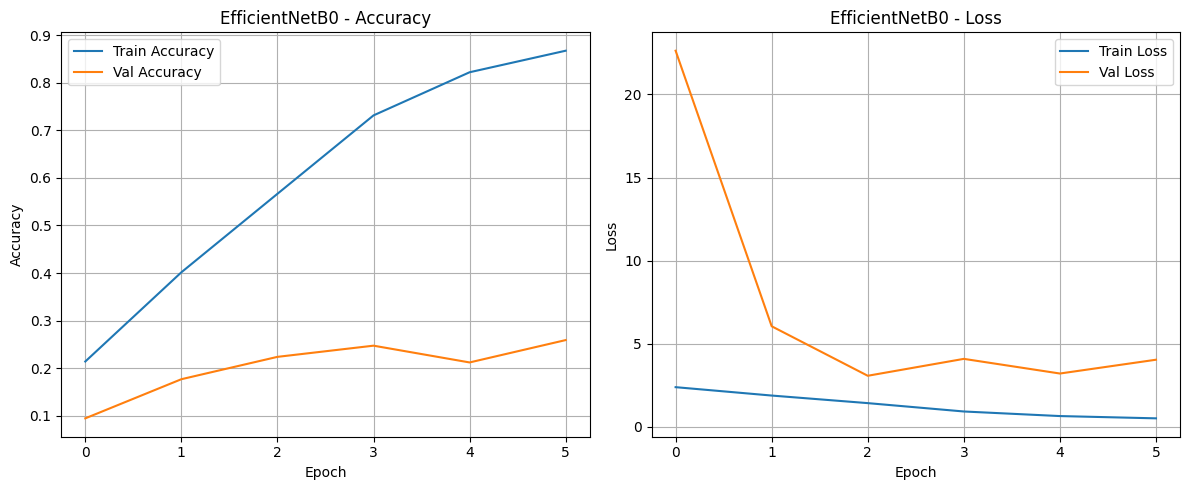

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_multiclass_basic_cnn_filtered_with_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_multiclass_basic_cnn_filtered_with_aug.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNetB0 - Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_multiclass_basic_cnn_filtered_with_aug.history['loss'], label='Train Loss')
plt.plot(history_multiclass_basic_cnn_filtered_with_aug.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNetB0 - Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Inception with Filteration and Augmentation

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3
num_classes = len(df['target'].unique())

model_inception_filtered_aug = build_inception_model(
    num_classes=num_classes,
    use_imagenet=True,
    input_shape=(img_height, img_width, 3),
    dropout_rate=0.5,
    fine_tune_at=len(InceptionV3(include_top=False).layers) - 50,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-4
)

model_inception_filtered_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

checkpoint_cb = ModelCheckpoint(
    "inception_fracture_best.h5",
    save_best_only=True,
    monitor="val_loss"
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_inception_filtered_aug = model_inception_filtered_aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/50


<ipython-input-57-d6d9567f0a23>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = cm.get_cmap(cmap)(norm)


1220/1221 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2286 - loss: 2.2072

1221/1221 ━━━━━━━━━━━━━━━━━━━━ 90s 54ms/step - accuracy: 0.2288 - loss: 2.2067 - val_accuracy: 0.3294 - val_loss: 2.0679
Epoch 2/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.7343 - loss: 0.9360 - val_accuracy: 0.4118 - val_loss: 2.6225
Epoch 3/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.9042 - loss: 0.3979 - val_accuracy: 0.4706 - val_loss: 2.3418
Epoch 4/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9388 - loss: 0.2640 - val_accuracy: 0.4118 - val_loss: 2.8160


In [ ]:
test_loss, test_acc = model_inception_filtered_aug.evaluate(test_generator)
print(f"InceptionV3 - Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.2573 - loss: 2.6687
InceptionV3 - Test loss: 2.5844, Test acc: 0.2627


In [ ]:
y_pred_probs = model_inception_filtered_aug.predict(X_test)

# Get predicted and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print("Classification Report:\n")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Classification Report:

                       precision    recall  f1-score   support

    Avulsion fracture     0.6000    0.4286    0.5000        14
  Comminuted fracture     0.3846    0.3571    0.3704        14
 Fracture Dislocation     0.2857    0.2105    0.2424        19
  Greenstick fracture     0.3226    0.6250    0.4255        16
    Hairline Fracture     0.1429    0.2000    0.1667        10
    Impacted fracture     0.1765    0.3333    0.2308         9
Longitudinal fracture     0.0000    0.0000    0.0000        12
     Oblique fracture     0.1739    0.2500    0.2051        16
Pathological fracture     0.5000    0.2222    0.3077        18
      Spiral Fracture     0.2500    0.0833    0.1250        12

             accuracy                         0.2786       140
            macro avg     0.2836    0.2710    0.2574       140
         weighted avg     0.3012    0.2786    0.2690       140



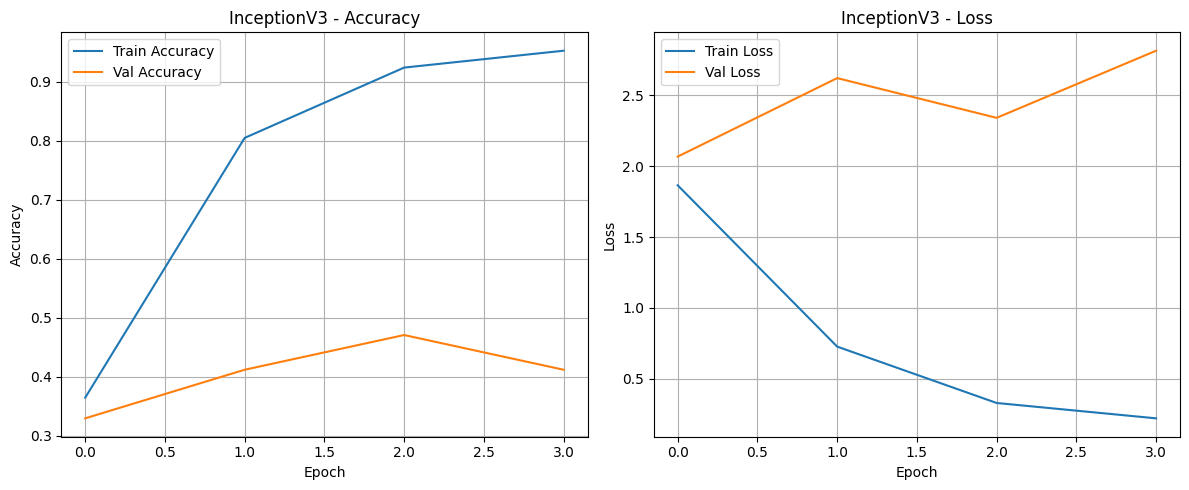

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_inception_filtered_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_inception_filtered_aug.history['val_accuracy'], label='Val Accuracy')
plt.title('InceptionV3 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_inception_filtered_aug.history['loss'], label='Train Loss')
plt.plot(history_inception_filtered_aug.history['val_loss'], label='Val Loss')
plt.title('InceptionV3 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### The following experiments use the filtered, augmented dataset but now restricted to just three fracture classes with the largest sample sizes.

* As a prefiltering step, the inception model we built ealier is used to clean the dataset, keeping only the likely fractured images making the multiclass classifiers job easier.

In previous attempts at just doing the multiclass classification of bone fractures with all 10 classes, we were not achieving an above 40% accuracy.



## This yields our most successful result

In [ ]:
# Collect the data and create a DataFrame
raw_data = collect_image_data_paths(path)
raw_df = pd.DataFrame(raw_data)

# Load all images
X = np.array([np.array(Image.open(p).resize((224, 224)).convert('RGB')) / 255.0 for p in raw_df['path']])
y = np.array(raw_df['target'].tolist())

# Predict fractures
fracture_preds = model_final_inception.predict(X, batch_size=32)
fracture_preds = (fracture_preds > 0.01).astype(int).flatten()

# We select a very low treshold of 0.01, as we know that these images should all theoretically be captured as Fractured.

# Filter only fractured images
df = raw_df[fracture_preds == 1].reset_index(drop=True)

# Define the 3 classes to include (customize as needed)
selected_classes = [
    'Fracture Dislocation',
    'Comminuted fracture',
    'Pathological fracture'
]

# Filter to selected classes only
df = df[df['target'].isin(selected_classes)].reset_index(drop=True)
print(df.head())

# Split Data into Train, Validation, and Test
train_df_full = df[df['split'] == 'Train']
train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.1,
    random_state=42,
    stratify=train_df_full['target']
)
test_df = df[df['split'] == 'Test']

# Define Original Augmentation Functions (10 Variations) (These were taken from )
def apply_color_map(ct_image, cmap='jet'):
    # Normalize avoiding divide-by-zero and apply colormap
    norm = (ct_image - np.min(ct_image)) / ((np.max(ct_image) - np.min(ct_image)) + 1e-7)
    colored = cm.get_cmap(cmap)(norm)
    return (colored[:, :, :3] * 255).astype(np.uint8)

def apply_adaptive_hist_eq(ct_image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(ct_image)
    return apply_color_map(enhanced, 'jet')

def apply_contrast_stretching(ct_image):
    min_val, max_val = np.min(ct_image), np.max(ct_image)
    stretched = (ct_image - min_val) / ((max_val - min_val) + 1e-7)
    return apply_color_map(stretched, 'jet')

def apply_gaussian_blur(ct_image):
    blurred = cv2.GaussianBlur(ct_image, (5, 5), 0)
    return apply_color_map(blurred, 'jet')

def apply_gamma_correction(ct_image, gamma=1.2):
    ct_float = ct_image.astype(np.float32)
    gamma_corr = np.power(ct_float / (np.max(ct_float) + 1e-7), gamma) * 255
    return apply_color_map(gamma_corr, 'jet')

def apply_lut_color_map(ct_image):
    return apply_color_map(ct_image, cmap='plasma')

def apply_alpha_blending(ct_image):
    thresholded = ct_image > 100
    colored = apply_color_map(ct_image, 'jet')
    mask = (thresholded.astype(np.uint8)) * 255
    mask_rgb = np.stack([mask, mask, mask], axis=-1)
    alpha = 0.5
    blended = alpha * colored + (1 - alpha) * mask_rgb
    return blended.astype(np.uint8)

def apply_3d_rendering(ct_image):
    return apply_color_map(ct_image, 'jet')

def apply_heatmap(ct_image):
    norm = (ct_image - np.min(ct_image)) / ((np.max(ct_image) - np.min(ct_image)) + 1e-7)
    heatmap = cm.hot(norm)
    return (heatmap[:, :, :3] * 255).astype(np.uint8)

def apply_3d_volume_rendering(ct_image):
    return apply_color_map(ct_image, 'jet')

# Define Additional Augmentation Functions for X‑ray Data (5 Variations)
def apply_rotation(ct_image, angle=5):
    (h, w) = ct_image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(ct_image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return apply_color_map(rotated, 'jet')

def apply_translation(ct_image, tx=5, ty=5):
    (h, w) = ct_image.shape
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(ct_image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return apply_color_map(translated, 'jet')

def apply_brightness_contrast(ct_image, brightness=30, contrast=1.2):
    adjusted = ct_image.astype(np.float32) * contrast + brightness
    adjusted = np.clip(adjusted, 0, 255).astype(np.uint8)
    return apply_color_map(adjusted, 'jet')

def apply_gaussian_noise(ct_image, mean=0, sigma=10):
    noise = np.random.normal(mean, sigma, ct_image.shape)
    noisy = ct_image.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return apply_color_map(noisy, 'jet')

def apply_zoom(ct_image, scale=1.1):
    (h, w) = ct_image.shape
    new_h, new_w = int(h / scale), int(w / scale)
    start_row = (h - new_h) // 2
    start_col = (w - new_w) // 2
    cropped = ct_image[start_row:start_row + new_h, start_col:start_col + new_w]
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    return apply_color_map(zoomed, 'jet')


# Combine All Augmentation Functions, Original 10 variations + 5 additional variations

augmentation_functions = [
 apply_color_map,
   apply_adaptive_hist_eq,
   apply_contrast_stretching,
    apply_gaussian_blur,
    apply_gamma_correction,
    apply_lut_color_map,
    apply_alpha_blending,
    apply_3d_rendering,
    apply_heatmap,
    apply_3d_volume_rendering,
    apply_rotation,
    apply_translation,
    apply_brightness_contrast,
    apply_gaussian_noise,
    apply_zoom
]

# Utility Function to Load and Resize an Image
def load_image(img_path, target_size=(256, 256)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    return np.array(img)

# Custom Training Generator: Expand Each Image
def multi_augment_generator(df, batch_size, target_size=(256, 256), k=5):
    image_paths = df['path'].tolist()
    labels = df['target'].tolist()
    classes = sorted(df['target'].unique())
    class_indices = {c: i for i, c in enumerate(classes)}
    num_classes = len(classes)

    while True:
        batch_images = []
        batch_labels = []

        for path, label in zip(image_paths, labels):
            # Load and preprocess the original image
            original = load_image(path, target_size)
            normalized = original.astype(np.float32) / 255.0
            one_hot = np.zeros(num_classes, dtype=np.float32)
            one_hot[class_indices[label]] = 1.0

            # Add the original image
            batch_images.append(normalized)
            batch_labels.append(one_hot)

            # Convert to grayscale for augmentation
            gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)

            # Apply k random augmentations
            for func in random.sample(augmentation_functions, k=k):
                aug_img = func(gray).astype(np.float32) / 255.0
                batch_images.append(aug_img)
                batch_labels.append(one_hot)

            # Yield complete batches
            while len(batch_images) >= batch_size:
                yield (np.array(batch_images[:batch_size]), np.array(batch_labels[:batch_size]))
                batch_images = batch_images[batch_size:]
                batch_labels = batch_labels[batch_size:]

        # Yield remainder at end of epoch
        if batch_images:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images, batch_labels = [], []

# Create Validation and Test Generators Using ImageDataGenerator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 10
img_height = 224
img_width = 224

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Configure the Training Generator and Steps per Epoch
# Each original image is expanded to 1 original + 15 augmented variations = 16 samples.
steps_per_epoch = int(np.ceil(len(train_df) * 16 / batch_size))
train_generator = multi_augment_generator(train_df, batch_size, target_size=(img_height, img_width))

# Print
print(f"Original training samples: {len(train_df)}")
print(f"Effective training samples (with augmentation): {len(train_df) * 16}")
print("\nTrain samples per class:")
print(train_df['target'].value_counts())
print("\nValidation samples per class:")
print(val_df['target'].value_counts())
print("\nTest samples per class:")
print(test_df['target'].value_counts())

class_idx_to_name = {v: k for k, v in val_generator.class_indices.items()}
print(f"Class index to name mapping: {class_idx_to_name}")
print(f"Validation class indices: {val_generator.class_indices}")

/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Spiral Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Impacted fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Greenstick fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Pathological fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Oblique fracture
/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Fracture Dislocation
/k

In [ ]:
# Define fracture_types
fracture_types = [
    'Fracture Dislocation',
    'Comminuted fracture',
    'Pathological fracture'
]

# Display Label
label_mapping = {i: fracture_types[i] for i in range(len(fracture_types))}
print("Label mapping:")

for label, fracture_name in label_mapping.items():
    print(f"{label}: {fracture_name}")

Label mapping:
0: Fracture Dislocation
1: Comminuted fracture
2: Pathological fracture


### Visualisation of the Augmentations that are applied.

<ipython-input-66-c2132695844b>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = cm.get_cmap(cmap)(norm)


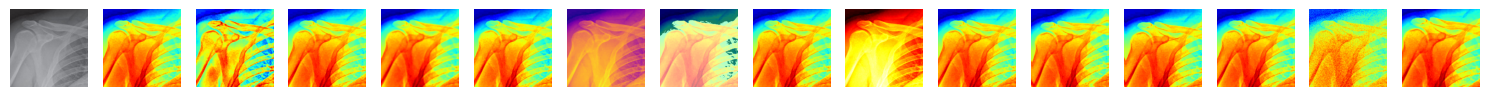

In [ ]:
# Display an example image and its variations
# Choose one sample image from the training DataFrame.
sample_image_path = train_df.iloc[50]['path']

# Load the image in RGB format and resize.
original_image = load_image(sample_image_path, target_size=(img_height, img_width))

# Prepare a list to store the variations.
variations = []

# Add the original image.
variations.append(original_image)

# Convert the original image to grayscale as required by the augmentation functions.
gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)

# Apply each augmentation function.
for func in augmentation_functions:
    aug_img = func(gray)
    variations.append(aug_img)

# Plot the original and augmented images side by side.
num_variations = len(variations)
fig, axes = plt.subplots(1, num_variations, figsize=(15, 3))
for ax, img in zip(axes, variations):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

### To improve accuracy despite limited samples per category, we restrict the classification task to the three fracture types with the largest sample counts and apply customized colorization-based augmentations to bolster the training data, as done earlier

### Simple CNN with reduced class and augmentation:

In [ ]:
# Basic CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.optimizers import Adam

cnn_model = Sequential([
    # 1st convolutional block with L2 regularization and dropout
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # 2nd convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # 3rd convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Fully connected layers with regularization
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.13),
    Dense(3, activation='softmax', kernel_regularizer=l2(0.001))
])

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_770 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_773         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_771 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_774         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_772 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_775         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_773 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_776         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_774 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_777         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_775 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_778         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_779         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,673,123 (197.12 MB)

 Trainable params: 51,671,203 (197.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Train
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               loss="categorical_crossentropy",
               metrics=["accuracy"])

# Train the model using the training and validation datasets
history_model2 = cnn_model.fit(
    train_generator, validation_data=val_generator, epochs = 75,
steps_per_epoch = steps_per_epoch, callbacks=[checkpoint_cb, earlystop_cb])

<ipython-input-66-c2132695844b>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = cm.get_cmap(cmap)(norm)


Epoch 1/75
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4324 - loss: 2.8439

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


496/496 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.4327 - loss: 2.8424 - val_accuracy: 0.4857 - val_loss: 2.5999
Epoch 2/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.6314 - loss: 2.1081 - val_accuracy: 0.2857 - val_loss: 4.5437
Epoch 3/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.6840 - loss: 1.9762 - val_accuracy: 0.3714 - val_loss: 2.7711
Epoch 4/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6901 - loss: 1.8891 - val_accuracy: 0.4286 - val_loss: 2.4293
Epoch 5/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6907 - loss: 1.7978 - val_accuracy: 0.4000 - val_loss: 2.6388
Epoch 6/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7195 - loss: 1.7326 - val_accuracy: 0.4571 - val_loss: 2.2634
Epoch 7/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7037 - loss: 1.7256 - val_accuracy: 0.4286 - val_loss: 2.6782
Epoch 8/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.7460 - loss: 1.5978 - val_accurac

496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7832 - loss: 1.3672 - val_accuracy: 0.4857 - val_loss: 2.0073
Epoch 12/75
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7709 - loss: 1.3431

496/496 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7709 - loss: 1.3430 - val_accuracy: 0.5714 - val_loss: 1.8513
Epoch 13/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7779 - loss: 1.2932 - val_accuracy: 0.4571 - val_loss: 2.4017
Epoch 14/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7646 - loss: 1.2847 - val_accuracy: 0.4286 - val_loss: 1.8779
Epoch 15/75
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7928 - loss: 1.2082

496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7927 - loss: 1.2082 - val_accuracy: 0.6000 - val_loss: 1.7780
Epoch 16/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7904 - loss: 1.1909 - val_accuracy: 0.5429 - val_loss: 2.0667
Epoch 17/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7998 - loss: 1.1643 - val_accuracy: 0.5429 - val_loss: 1.9566
Epoch 18/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7828 - loss: 1.1888

496/496 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7828 - loss: 1.1888 - val_accuracy: 0.6000 - val_loss: 1.7183
Epoch 19/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.7854 - loss: 1.1517 - val_accuracy: 0.5714 - val_loss: 1.9972
Epoch 20/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.7950 - loss: 1.1575 - val_accuracy: 0.5429 - val_loss: 1.7221
Epoch 21/75
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8109 - loss: 1.0920

496/496 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8109 - loss: 1.0920 - val_accuracy: 0.6571 - val_loss: 1.6520
Epoch 22/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.7958 - loss: 1.0979 - val_accuracy: 0.6000 - val_loss: 1.8133
Epoch 23/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7965 - loss: 1.1078 - val_accuracy: 0.5714 - val_loss: 1.9121
Epoch 24/75
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8109 - loss: 1.0814

496/496 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.8109 - loss: 1.0813 - val_accuracy: 0.6286 - val_loss: 1.6290
Epoch 25/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7990 - loss: 1.0594 - val_accuracy: 0.6000 - val_loss: 1.7374
Epoch 26/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8198 - loss: 1.0139 - val_accuracy: 0.6000 - val_loss: 1.6410
Epoch 27/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8031 - loss: 1.0345 - val_accuracy: 0.6571 - val_loss: 1.6935


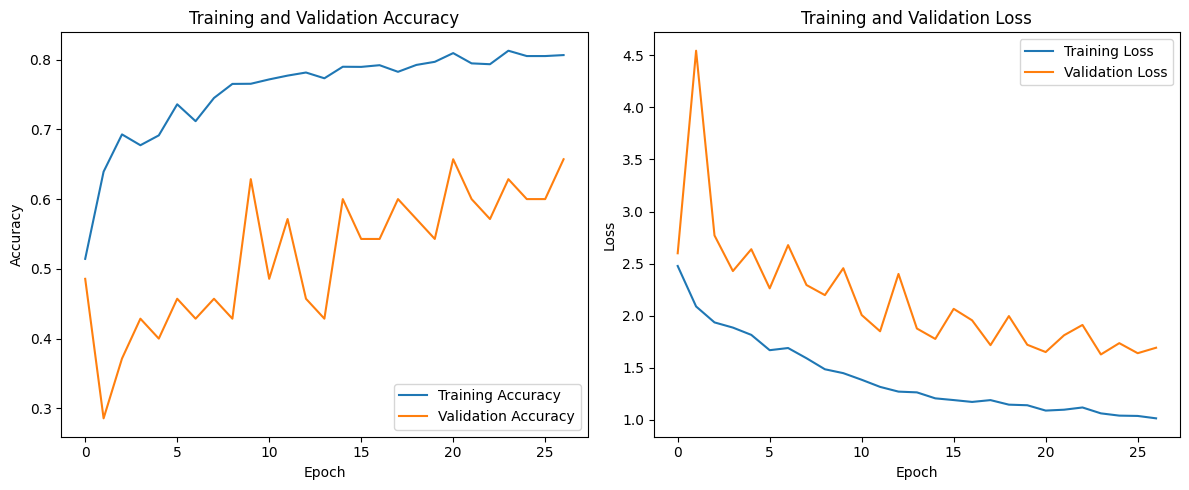

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))  # width=12, height=5

plt.subplot(1, 2, 1)
plt.plot(history_model2.history['accuracy'], label='Training Accuracy')
plt.plot(history_model2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_model2.history['loss'], label='Training Loss')
plt.plot(history_model2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
loss, accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.5628 - loss: 1.9127
Test Loss: 2.1483
Test Accuracy: 0.5217


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Classification Report:
                       precision    recall  f1-score   support

  Comminuted fracture       0.35      0.58      0.44        12
 Fracture Dislocation       0.33      0.24      0.28        17
Pathological fracture       0.36      0.29      0.32        17

             accuracy                           0.35        46
            macro avg       0.35      0.37      0.35        46
         weighted avg       0.35      0.35      0.34        46



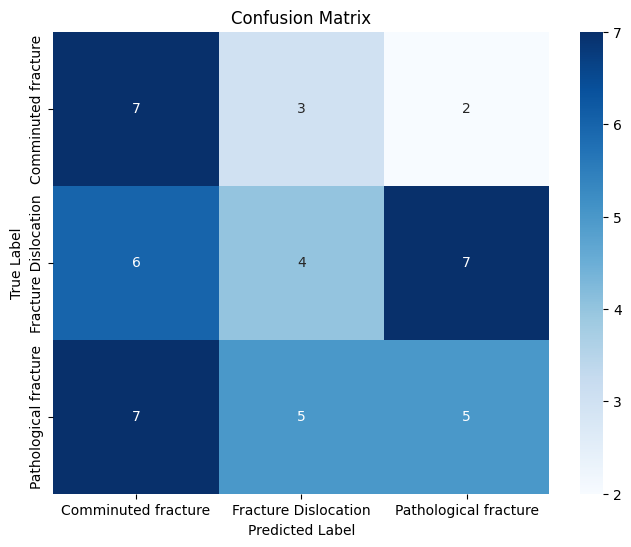

In [ ]:
# Get true labels and predictions
y_true = test_generator.classes  # class indices
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices

# Convert class indices to names
class_labels = list(class_idx_to_name.values())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### **Result Analysis:** The basic CNN model demonstrates significant limitations in classifying bone fractures. Although training accuracy improves steadily to around 80%, validation and test accuracies remain low and unstable, with the final test accuracy around 45%. This indicates the model is overfitting the training data but fails to generalize to new, unseen images. The high and noisy validation loss further supports this observation. Given the complexity of medical imaging tasks, this simple CNN lacks the capacity and robustness needed for reliable fracture detection. Stronger architectures like EfficientNetB0, combined with careful data augmentation, fine-tuning, and class balancing, are necessary to achieve performance levels suitable for clinical or real-world application.

### Inception with reduced classes and augmentation:

In [ ]:
import tensorflow as tf

def build_inception_model(
    num_classes: int = 3,
    use_imagenet: bool = True,
    input_shape: tuple = (224, 224, 3),
    dropout_rate: float = 0.5,
    fine_tune_at: int = 249,
    base_trainable: bool = False,
    bn_trainable: bool = True,
    learning_rate: float = 1e-4
) -> tf.keras.Model:
    """
    Returns an InceptionV3-based model.

    Args:
      num_classes: number of output classes (1 for binary).
      use_imagenet: whether to initialize with ImageNet weights.
      input_shape: model input size.
      dropout_rate: dropout after global pooling.
      fine_tune_at: layer index in base_model at which to start fine‑tuning.
      base_trainable: whether to train base_model layers.
      bn_trainable: whether BatchNormalization layers stay trainable.
      learning_rate: for the Adam optimizer.

    """
    # Base feature extractor
    base = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet' if use_imagenet else None,
        input_shape=input_shape
    )
    # Optionally freeze base
    base.trainable = base_trainable
    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = bn_trainable

    # Head
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if dropout_rate:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)

    model = tf.keras.Model(inputs=base.input, outputs=outputs)

    # Fine‑tune last N layers (except batch‑norm)
    if fine_tune_at is not None:
        for layer in base.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base.layers[fine_tune_at:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=['accuracy']
    )
    return model


In [ ]:
# Build the model
model_multiclass_inception = build_inception_model(
    num_classes=3,
    use_imagenet=True,
    dropout_rate=0.5,
    fine_tune_at= len(tf.keras.applications.InceptionV3(include_top=False).layers) - 50,
    base_trainable=False,
    bn_trainable=True,
    learning_rate=1e-2
)

model_multiclass_inception.summary()

# Prepare callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "inception_best.h5",
    save_best_only=True,
    monitor="val_loss"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_870 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_870[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_846      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_871 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_846[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_871[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_847      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_872 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_847[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_872[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_848      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_48    │ (None, 54, 54,    │          0 │ activation_848[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_873 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_48… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_873[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_849      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_874 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_849[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_874[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_850      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 7,179,459 (27.39 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

In [ ]:
# Train
history = model_multiclass_inception.fit(
    train_generator,
    validation_data=val_generator, epochs = 75,
    steps_per_epoch = steps_per_epoch, callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/75


<ipython-input-66-c2132695844b>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = cm.get_cmap(cmap)(norm)


495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4040 - loss: 2.1034

496/496 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.4042 - loss: 2.1007 - val_accuracy: 0.6000 - val_loss: 1.4046
Epoch 2/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6472 - loss: 0.8348 - val_accuracy: 0.5143 - val_loss: 1.8832
Epoch 3/75
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8271 - loss: 0.4501

496/496 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8272 - loss: 0.4499 - val_accuracy: 0.7143 - val_loss: 0.9637
Epoch 4/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9169 - loss: 0.2258 - val_accuracy: 0.7143 - val_loss: 1.2627
Epoch 5/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9825 - loss: 0.0590 - val_accuracy: 0.7429 - val_loss: 0.9707
Epoch 6/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9768 - loss: 0.0656 - val_accuracy: 0.6857 - val_loss: 1.9849
Epoch 7/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9841 - loss: 0.0487 - val_accuracy: 0.6000 - val_loss: 2.5276
Epoch 8/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9643 - loss: 0.1078 - val_accuracy: 0.7429 - val_loss: 1.2827
Epoch 9/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9743 - loss: 0.0749 - val_accuracy: 0.7429 - val_loss: 1.3552
Epoch 10/75
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9938 - loss: 0.0244 - val_accura

85% Validation Accuracy



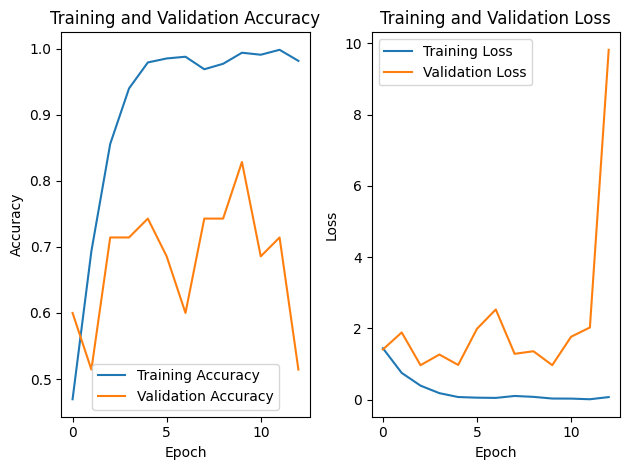

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))  # width=12, height=5

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate test set
loss, accuracy = model_multiclass_inception.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6871 - loss: 1.6935
Test Loss: 1.4315
Test Accuracy: 0.6739


This is the Test accuracy

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classification Report:
                       precision    recall  f1-score   support

  Comminuted fracture       0.18      0.17      0.17        12
 Fracture Dislocation       0.35      0.35      0.35        17
Pathological fracture       0.28      0.29      0.29        17

             accuracy                           0.28        46
            macro avg       0.27      0.27      0.27        46
         weighted avg       0.28      0.28      0.28        46



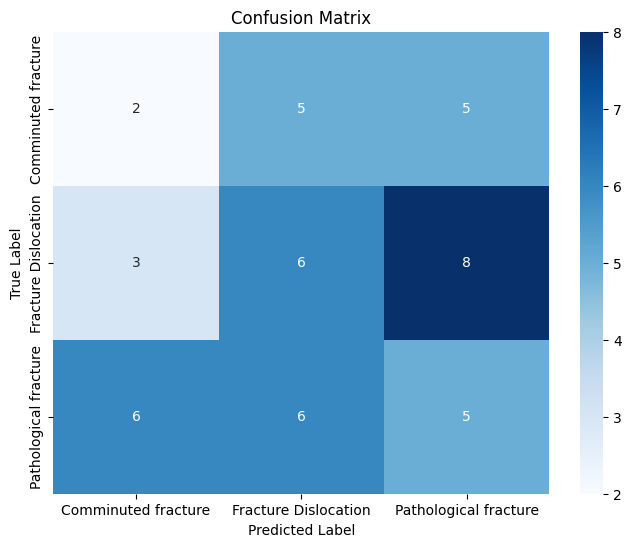

In [ ]:
# Get true labels and predictions
y_true = test_generator.classes  # class indices
y_pred_probs = model_multiclass_inception.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices

# Convert class indices to names
class_labels = list(class_idx_to_name.values())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### **Result Analysis:** The Inception-based model shows a notable improvement over the basic CNN, achieving a higher final test accuracy of approximately 68.6%. Training accuracy quickly approaches 100%, while validation accuracy stabilizes between 65–75%, suggesting better learning capacity but also some degree of overfitting. The validation loss curve indicates significant fluctuations and an upward trend, implying potential instability and generalization challenges. Despite this, the model demonstrates much stronger performance than the baseline CNN, indicating that deeper and more sophisticated architectures like Inception are better suited for the complex task of fracture classification from X-ray images. Further regularization, fine-tuning, or data augmentation could likely enhance stability and performance even more.

### EfficientnetB0 with reduced classes and augmentation:

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build model
input_layer = Input(shape=(224, 224, 3))

# Normalization
x = tf.keras.layers.Rescaling(1./255)(input_layer)

# EfficientNetB0 Base
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False  # Freeze base initially

# Top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output_layer = Dense(3, activation='softmax')(x)  # Correct for multi-class

model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Phase 1: Train top layers only
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Phase 2: Fine-tune
base_model.trainable = True
for layer in base_model.layers[:150]:  # Freeze lower layers, unfreeze top layers
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_17[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ rescaling_6[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_7[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_8[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20


<ipython-input-66-c2132695844b>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = cm.get_cmap(cmap)(norm)


496/496 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - accuracy: 0.3410 - loss: 1.1302 - val_accuracy: 0.3429 - val_loss: 1.1013 - learning_rate: 1.0000e-05
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.3462 - loss: 1.1176 - val_accuracy: 0.3429 - val_loss: 1.0993 - learning_rate: 1.0000e-05
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.3440 - loss: 1.1123 - val_accuracy: 0.3429 - val_loss: 1.0989 - learning_rate: 1.0000e-05
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.3374 - loss: 1.1132 - val_accuracy: 0.3429 - val_loss: 1.0983 - learning_rate: 1.0000e-05
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.3480 - loss: 1.1111 - val_accuracy: 0.3429 - val_loss: 1.0983 - learning_rate: 1.0000e-05
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.3519 - loss: 1.1102 - val_accuracy: 0.3429 - val_loss: 1.0986 - learning_rate: 1.0000e-05
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accurac

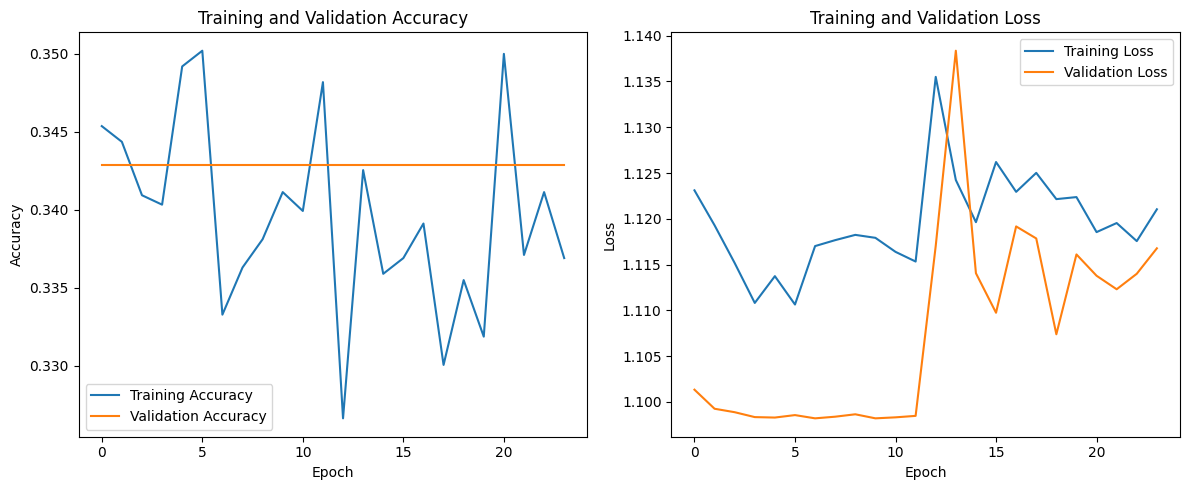

In [ ]:
# Plot training curves
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate test set
loss, accuracy = model.evaluate(test_generator, verbose=1)[0:2]
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2383 - auc: 0.4440 - loss: 1.1409
Test Loss: 1.1364
Test Accuracy: 0.2609


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Classification Report:
                       precision    recall  f1-score   support

  Comminuted fracture       0.26      1.00      0.41        12
 Fracture Dislocation       0.00      0.00      0.00        17
Pathological fracture       0.00      0.00      0.00        17

             accuracy                           0.26        46
            macro avg       0.09      0.33      0.14        46
         weighted avg       0.07      0.26      0.11        46



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


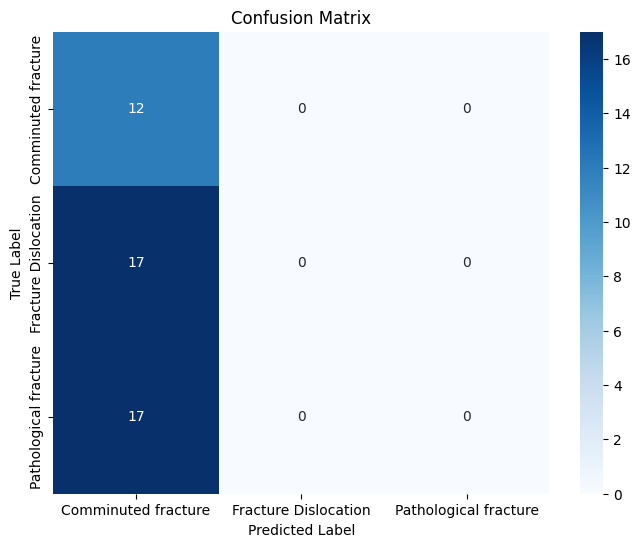

In [ ]:
# Get true labels and predictions
y_true = test_generator.classes  # class indices
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices

# Convert class indices to names
class_labels = list(class_idx_to_name.values())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### **Result Analysis:** The results from training the EfficientNetB0 model demonstrate that it struggles to perform well on the bone fracture classification task, achieving only around 35% test accuracy. Both the training and validation accuracies remain low and unstable throughout the training process, and the model shows clear signs of underfitting, where it cannot adequately learn patterns from the data. A key reason for this poor performance is likely the small size of the dataset, which is insufficient for a deep architecture like EfficientNetB0 to fully leverage its representational capacity. Models of this complexity typically require much larger and more diverse datasets to learn robust, generalizable features. Without enough training examples, the model cannot extract meaningful patterns, leading to weak classification ability even after extensive training.